## Detecting Phishing Websites using Neural Networks

The aim of the experiments conducted in this notebook is to give an idea of how modern _phishing website attacks_ can be prevented using machine learning. To do this, we are going to use the [Phishing Websites' Dataset](https://archive.ics.uci.edu/ml/datasets/phishing+websites). The viewers are requested to take a look at [this paper](https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Phishing%20Websites%20Features.docx) by the authors of the dataset. The paper discusses the data generation strategy in details and how the authors were able to come up with the most significant set of features for _detecting phishing websites_. 

We will start off the experiments by importing the initial set of Python modules.  

In [1]:
# Filter the uneccesary warnings
import warnings
warnings.filterwarnings("ignore")

# Import pandas and numpy
import pandas as pd
import numpy as np

### Data loading and basic display

In [2]:
data = pd.read_csv('Phishing.csv')
data.head(10)

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1
5,-1,0,-1,1,-1,-1,1,1,-1,1,1,-1,1,0,0,-1,-1,-1,0,1,1,1,1,1,1,1,-1,1,-1,-1,1
6,1,0,-1,1,1,-1,-1,-1,1,1,1,1,-1,-1,0,-1,-1,-1,0,1,1,1,1,1,-1,-1,-1,1,0,-1,-1
7,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,0,1,-1
8,1,0,-1,1,1,-1,1,1,-1,1,1,-1,1,0,1,-1,1,1,0,1,1,1,1,1,-1,1,1,1,0,1,1
9,1,1,-1,1,1,-1,-1,1,-1,1,1,1,1,0,1,-1,1,1,0,1,1,1,1,1,-1,0,-1,1,0,1,-1


### Displaying it in a bit easier manner

In [3]:
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
having_IP_Address,-1,1,1,1,1,-1,1,1,1,1
URL_Length,1,1,0,0,0,0,0,0,0,1
Shortining_Service,1,1,1,1,-1,-1,-1,1,-1,-1
having_At_Symbol,1,1,1,1,1,1,1,1,1,1
double_slash_redirecting,-1,1,1,1,1,-1,1,1,1,1
Prefix_Suffix,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
having_Sub_Domain,-1,0,-1,-1,1,1,-1,-1,1,-1
SSLfinal_State,-1,1,-1,-1,1,1,-1,-1,1,1
Domain_registeration_length,-1,-1,-1,1,-1,-1,1,1,-1,-1
Favicon,1,1,1,1,1,1,1,1,1,1


**Quick observation**: The dataset is filled with -1, 0 and 1 values. Nothing else. So, we might not need fancy data scaling. 

### Inspecting data dimensions and column names

In [4]:
# Data dimension
data.shape

(11055, 31)

In [5]:
# Data columns
data.columns

Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')

### Finding out the distribution of the class labels and preparing a report

In [6]:
from collections import Counter

classes = Counter(data['Result'].values)
classes.most_common()

[(1, 6157), (-1, 4898)]

In [7]:
class_dist = pd.DataFrame(classes.most_common(), columns=['Class', 'Num_Observations'])
class_dist

,Class,Num_Observations
0,1,6157
1,-1,4898


### Preparing a basic bar plot of the distribution of the class labels

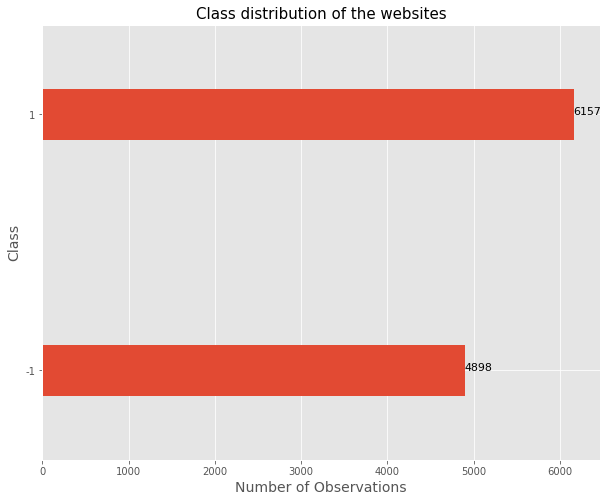

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

subplot = class_dist.groupby('Class')['Num_Observations'].sum().plot(kind='barh', width=0.2, figsize=(10,8))

subplot.set_title('Class distribution of the websites', fontsize = 15)
subplot.set_xlabel('Number of Observations', fontsize = 14)
subplot.set_ylabel('Class', fontsize = 14)

for i in subplot.patches:
    subplot.text(i.get_width()+0.1, i.get_y()+0.1, \
            str(i.get_width()), fontsize=11)

### Finding out the summary statistics from the data

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
having_IP_Address,11055.0,0.313795,0.949534,-1.0,-1.0,1.0,1.0,1.0
URL_Length,11055.0,-0.633198,0.766095,-1.0,-1.0,-1.0,-1.0,1.0
Shortining_Service,11055.0,0.738761,0.673998,-1.0,1.0,1.0,1.0,1.0
having_At_Symbol,11055.0,0.700588,0.713598,-1.0,1.0,1.0,1.0,1.0
double_slash_redirecting,11055.0,0.741474,0.671011,-1.0,1.0,1.0,1.0,1.0
Prefix_Suffix,11055.0,-0.734962,0.678139,-1.0,-1.0,-1.0,-1.0,1.0
having_Sub_Domain,11055.0,0.063953,0.817518,-1.0,-1.0,0.0,1.0,1.0
SSLfinal_State,11055.0,0.250927,0.911892,-1.0,-1.0,1.0,1.0,1.0
Domain_registeration_length,11055.0,-0.336771,0.941629,-1.0,-1.0,-1.0,1.0,1.0
Favicon,11055.0,0.628584,0.777777,-1.0,1.0,1.0,1.0,1.0


### Finding out the basic information of the columns present in the dataset

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

### Mapping the `-1` values to `0` in the class labels

In [11]:
data.rename(columns={'Result': 'Class'}, inplace=True)

data['Class'] = data['Class'].map({-1:0, 1:1})
data['Class'].unique()

array([0, 1])

### Inspection of null values in the dataset

In [12]:
data.isna().sum()

having_IP_Address              0
URL_Length                     0
Shortining_Service             0
having_At_Symbol               0
double_slash_redirecting       0
Prefix_Suffix                  0
having_Sub_Domain              0
SSLfinal_State                 0
Domain_registeration_length    0
Favicon                        0
port                           0
HTTPS_token                    0
Request_URL                    0
URL_of_Anchor                  0
Links_in_tags                  0
SFH                            0
Submitting_to_email            0
Abnormal_URL                   0
Redirect                       0
on_mouseover                   0
RightClick                     0
popUpWidnow                    0
Iframe                         0
age_of_domain                  0
DNSRecord                      0
web_traffic                    0
Page_Rank                      0
Google_Index                   0
Links_pointing_to_page         0
Statistical_report             0
Class     

### Data splitting

In [13]:
from sklearn.model_selection import train_test_split

X = data.iloc[:,0:30].values.astype(int)
y = data.iloc[:,30].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.seed(7))

### Fitting the training data to the Logistic Regression classifier

The  dataset  contains  all  of  its  values  in -1,  0  and  1.  So,  linear  models  like  Logistic  Regression  are specifically  good  at  figuring  out  the  relationships  between  the  features  of  the  dataset  which  only contain -1, 0 and 1 values. 

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Model evaluation

In [15]:
from sklearn.metrics import accuracy_score, classification_report

print('Accuracy score of the Logistic Regression classifier with default hyperparameter values {0:.2f}%'.format(accuracy_score(y_test, logreg.predict(X_test))*100.))
print('\n')
print('----Classification report of the Logistic Regression classifier with default hyperparameter value----')
print('\n')
print(classification_report(y_test, logreg.predict(X_test), target_names=['Phishing Websites', 'Normal Websites']))

Accuracy score of the Logistic Regression classifier with default hyperparameter values 93.71%


----Classification report of the Logistic Regression classifier with default hyperparameter value----


                   precision    recall  f1-score   support

Phishing Websites       0.94      0.92      0.93       974
  Normal Websites       0.94      0.95      0.94      1237

         accuracy                           0.94      2211
        macro avg       0.94      0.94      0.94      2211
     weighted avg       0.94      0.94      0.94      2211



### Hyperparameter tuning with random searching

In [16]:
# Import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define the grid of values
penalty = ['l1', 'l2']
C = [0.8, 0.9, 1.0]
tol = [0.01, 0.001 ,0.0001]
max_iter = [100, 150, 200, 250]

# Create a dictionary where tol and max_iter are keys and the lists of their values are the corresponding values
param_grid = dict(penalty=penalty, C=C, tol=tol, max_iter=max_iter)

In [17]:
# Instantiate RandomizedSearchCV with the required parameters
random_model = RandomizedSearchCV(estimator=logreg, param_distributions=param_grid, cv=5)

# Fit random_model to the data
random_model_result = random_model.fit(X_train, y_train)

# Summarize results
best_score, best_params = random_model_result.best_score_, random_model_result.best_params_
print("Best score: %.2f using %s" % (best_score*100., best_params))

Best score: 92.41 using {'tol': 0.01, 'penalty': 'l2', 'max_iter': 100, 'C': 0.9}


### Trying to improve the predictive performance with Neural Networks

In [18]:
# Imports
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import *

In [19]:
# Model building using the Sequential API
model = Sequential()

model.add(Dense(40, activation='relu',
          kernel_initializer='uniform',input_dim=X.shape[1]))
model.add(Dense(30, activation='relu',
          kernel_initializer='uniform'))
model.add(Dense(1,  activation='sigmoid', 
          kernel_initializer='uniform'))

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1240      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


### Defining an EarlyStopping callback, training the model and evaluating the model

In [21]:
from keras import callbacks

es_cb = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=5)

In [22]:
history = model.fit(X_train, y_train, batch_size=64, epochs=128, verbose=1, callbacks=[es_cb])

scores = model.evaluate(X_test, y_test)
print('\nAccuracy score of the Neural Network with basic hyperparameter settings {0:.2f}%'.format(scores[1]*100))

Epoch 1/128
139/139 [==============================] - 0s 967us/step - loss: 0.4173 - accuracy: 0.8227
Epoch 2/128
139/139 [==============================] - 0s 1ms/step - loss: 0.2025 - accuracy: 0.9216
Epoch 3/128
139/139 [==============================] - 0s 994us/step - loss: 0.1962 - accuracy: 0.9247
Epoch 4/128
139/139 [==============================] - 0s 967us/step - loss: 0.1926 - accuracy: 0.9245
Epoch 5/128
139/139 [==============================] - 0s 1ms/step - loss: 0.1892 - accuracy: 0.9239
Epoch 6/128
139/139 [==============================] - 0s 973us/step - loss: 0.1867 - accuracy: 0.9274
Epoch 7/128
139/139 [==============================] - 0s 1ms/step - loss: 0.1840 - accuracy: 0.9257
Epoch 8/128
139/139 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9248
Epoch 9/128
139/139 [==============================] - 0s 949us/step - loss: 0.1787 - accuracy: 0.9277
Epoch 10/128
139/139 [==============================] - 0s 964us/step - loss: 0.1

###  Visualizing the performance of the network

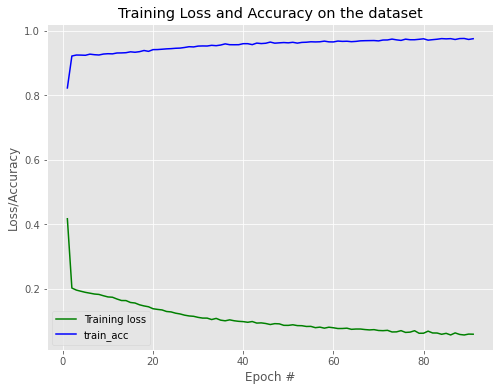

In [43]:
N = 91

plt.figure(figsize=(8,6))
loss_train = history.history['loss']
loss_val = history.history['accuracy']
epochs = range(1,92)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='train_acc')
#plt.plot(np.arange(0, N), label="train_loss")
#plt.plot(np.arange(0, N),  label="train_acc")

plt.title("Training Loss and Accuracy on the dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="middle")
plt.show()

### Model enhancement with TDLHBA hyperparameters and visualization

`TDLHBA` is technique introduced [in this paper](https://dl.acm.org/citation.cfm?id=3227655). We will use hyperparameter values as presented in the paper to see the performance enhancement of the model. 

In [33]:
# Building the model with the same topology as specified in the above-mentioned paper

model_TDLHBA = Sequential()

model_TDLHBA.add(Dense(40, activation='relu',
          kernel_initializer='uniform',input_dim=30))
model_TDLHBA.add(Dense(30, activation='relu',
          kernel_initializer='uniform'))
model_TDLHBA.add(Dense(1,  activation='sigmoid', 
          kernel_initializer='uniform'))

adam = Adam(lr=0.0017470)
model_TDLHBA.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [34]:
history_TDLHBA = model_TDLHBA.fit(X_train, y_train, batch_size=10, epochs=100, verbose=1, callbacks=[es_cb])

scores = model_TDLHBA.evaluate(X_test, y_test)
print('\nAccuracy score of the Neural Network with TDLHBA hyperparameter settings {0:.2f}%'.format(scores[1]*100))

Epoch 1/100
885/885 [==============================] - 1s 945us/step - loss: 0.2368 - accuracy: 0.9098
Epoch 2/100
885/885 [==============================] - 1s 970us/step - loss: 0.1776 - accuracy: 0.9301
Epoch 3/100
885/885 [==============================] - 1s 946us/step - loss: 0.1621 - accuracy: 0.9354
Epoch 4/100
885/885 [==============================] - 1s 946us/step - loss: 0.1500 - accuracy: 0.9393
Epoch 5/100
885/885 [==============================] - 1s 968us/step - loss: 0.1395 - accuracy: 0.9434
Epoch 6/100
885/885 [==============================] - 1s 948us/step - loss: 0.1303 - accuracy: 0.9457
Epoch 7/100
885/885 [==============================] - 1s 943us/step - loss: 0.1238 - accuracy: 0.9474
Epoch 8/100
885/885 [==============================] - 1s 946us/step - loss: 0.1151 - accuracy: 0.9505
Epoch 9/100
885/885 [==============================] - 1s 966us/step - loss: 0.1056 - accuracy: 0.9551
Epoch 10/100
885/885 [==============================] - 1s 953us/step - l

ValueError: ignored

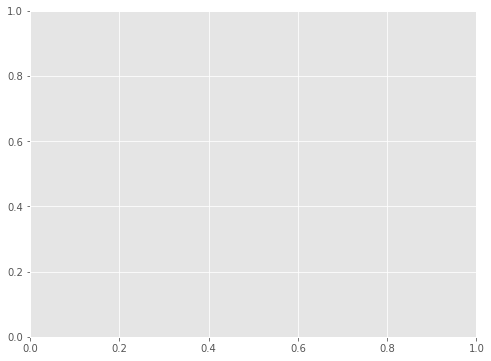

In [35]:
N = 48

plt.figure(figsize=(8,6))
plt.plot(np.arange(0, N), history_TDLHBA.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history_TDLHBA.history["acc"], label="train_acc")

plt.title("Training Loss and Accuracy on the dataset (with TDLHBA hyperparameter settings)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="middle")
plt.show()

So, in this notebook, we took a quick look at how we can employ machine learning and other data science techniques to detect phishing websites. As a next step, you can wrap the final model as a REST API endpoint and use it along with a browser add-on. 